# Feature Engineering

In [44]:
import sys, os
from plotly import io as pio
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree

In [27]:
# Path needs to be added manually to read from another folder
path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'utils')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)

from feature_engineering import getFeatureImportance, n_Features

pio.renderers.default='notebook'

In [59]:
df = pd.read_parquet("../data/cleaned_data.parquet")

In [60]:
df.shape

(12330, 18)

In [10]:
# bin SpecialDay at SpecialDay=0: [0] and SpecialDay=1: [0.2, 0.4, 0.6, 0.8, 1.0]
df['SpecialDay'] = pd.cut(df['SpecialDay'], bins=[0, 0.2, 1.1], labels=[0, 1], right=False, include_lowest=True)

In [12]:
# convert bool vars to int
df.Revenue = df.Revenue.replace({True: 1, False: 0})
df.Weekend = df.Weekend.replace({True: 1, False: 0})

In [13]:
# create dummy variables
df_1 = pd.get_dummies(df)

In [14]:
df_1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,OperatingSystems,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,1,...,False,False,False,False,False,False,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,2,...,False,False,False,False,False,False,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,4,...,False,False,False,False,False,False,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,3,...,False,False,False,False,False,False,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,3,...,False,False,False,False,False,False,False,False,False,True


In [15]:
# Separating the target variable
Y = df_1["Revenue"]
X = df_1.drop(["Revenue"], axis=1)

In [23]:
# Split data into an 80% train, 20% test set with the remaining data

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [24]:
# Tree model for feature selection

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [25]:
clf.get_n_leaves()

806

In [26]:
clf.get_depth()

27

In [28]:
# 10 most important features based on Gini
dt_importances = getFeatureImportance(clf, X_train)
n_Features(dt_importances, 10)

,importance
PageValues,0.437011
ProductRelated_Duration,0.091539
BounceRates,0.084201
ExitRates,0.067315
Administrative_Duration,0.060166
ProductRelated,0.055361
Administrative,0.039846
Region,0.028794
TrafficType,0.027640
Month_Nov,0.023981


In [29]:
# 10 least important features based on Gini
n_Features(dt_importances, 10, head=False)

,importance
Month_June,0.001689
Month_Jul,0.001547
Month_Oct,0.001378
SpecialDay_0,0.001268
VisitorType_Returning_Visitor,0.001179
Month_Sep,0.001044
VisitorType_Other,0.000590
Month_Feb,0.000587
Month_Aug,0.000435
SpecialDay_1,0.000396


**Observations:**
- The most important features based upon Gini scores are some of the values related to the Google analytics, with the most important being PageValues
- Many of the variables have Gini values approximating zero

**Impact**

- Variables with Gini lower than 0.05 should be removed



In [36]:
num_features = ['Administrative', 'Administrative_Duration', 'Informational', 
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues']

In [49]:
data = df[num_features]
cor_matrix = data.corr()
mask = np.triu(np.ones_like(cor_matrix, dtype=bool))

c:\Users\griff\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



<Axes: >

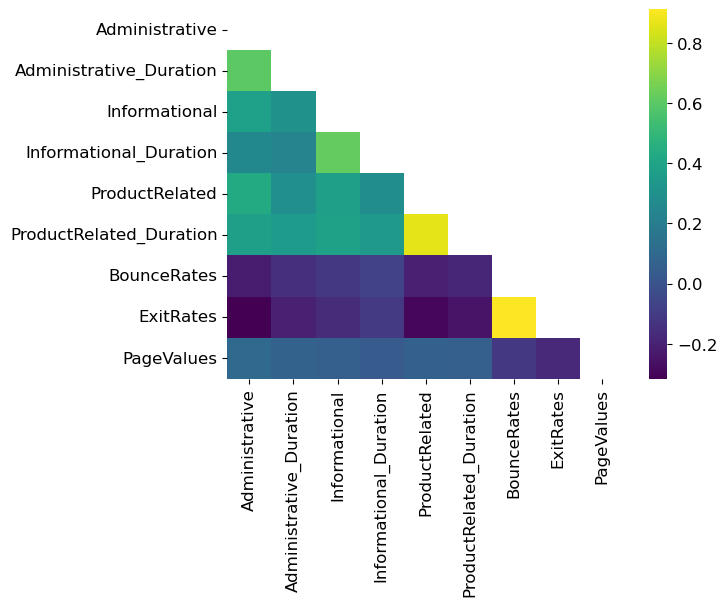

In [53]:
sns.heatmap(cor_matrix, annot=True, cmap = "viridis", mask=mask)

**Observations:**
- `BounceRates`&`ExitRates` and `ProductRelated`&`ProductRelated_Duration` are highly positively correlated 

- `Administrative`&`Administrative_Duration`, `Informational`&`Informational_Duration` are moderately positively correlated with each other.


**Impact**

- BounceRates will be removed because ExitRates had a higher value for Gini
- ProductRelated will be removed because ProductRelated_duration had a higher value for Gini


The top 4 features remaining in the model are PageValues, Administrative_Duration, ProductRelated_Duration, and BounceRates. 

In [54]:
# Remove Unimportant features
df_2 = df.drop(['Administrative', 'Informational', 'ProductRelated_Duration', 'Informational_Duration', 'ExitRates', 'OperatingSystems',
 'Browser', 'Region', 'TrafficType', 'Weekend', 'SpecialDay','Month', 'VisitorType'], axis=1)

In [56]:
def data_pipeline(dataframe, output_path):
    """ Takes a dataframe representing the processed data and
            an output path that represents the location where the file will be saved.
    """
    return dataframe.to_parquet(output_path)

In [58]:
output = "../data/cleaned_data_final.parquet"
data_pipeline(df_2, output)

## Summary

**Main Insights**

- After dummy variables were created, 13 variables were removed.
- The final data contains 5 variables, Revenue as the target and PageValues, Administrative_Duration, ProductRelated_Duration, and BounceRates.


**Implications for Modelling**

- Engineered and selected 5 features should enable a parsimonious set of predictors in the final model that mitigates overfitting